### **Support Vector Machine (SVM)**

### **1. Access to the DeepFake real and fake data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Unzip the our data
!unzip -qq "/content/drive/MyDrive/deepfake_dataset.zip"  -d "/content"

In [ ]:
# Set the directories to training, validation and test data
train_data_path = './deepfake_dataset/train/'
validation_data_path = './deepfake_dataset/validation/'
test_data_path = './deepfake_dataset/test/'

In [ ]:
# List out all image file name in the folders
from glob import glob # This library used to get all file in folder
from tqdm import tqdm # This lbrary used to show progress bar
import numpy as np
import cv2
width = 32 # Reshape image to new width
height = 32 # Reshape image to new height

def get_img_file(directory):
  """
  Get all real and fake file name in the directory, label real as 0s and fake as 1s
  """
  real_list = glob(directory + "real/*.jpg")
  fake_list = glob(directory + "fake/*.png")
  file_list = real_list + fake_list

  real_lb = [0] * len(real_list)
  fake_lb = [1] * len(fake_list)
  label_list = real_lb+fake_lb

  num_imgs = len(label_list)
  imgs = np.zeros((num_imgs, width, height, 3), dtype=np.int16)

  for idx, file in tqdm(enumerate(file_list)):
    img_bgr = cv2.imread(file) # Read image
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resize = cv2.resize(img_rgb, (width, height), interpolation = cv2.INTER_AREA) # Resize image
    imgs[idx] = img_resize

  return imgs, np.array(label_list)

train_imgs, train_lbs = get_img_file(train_data_path)
val_imgs, val_lbs = get_img_file(validation_data_path)
test_imgs, test_lbs = get_img_file(test_data_path)

14053it [00:14, 936.93it/s]
2003it [00:02, 793.44it/s]
4022it [00:04, 858.49it/s]


### **2. Visualize some random images in training set**

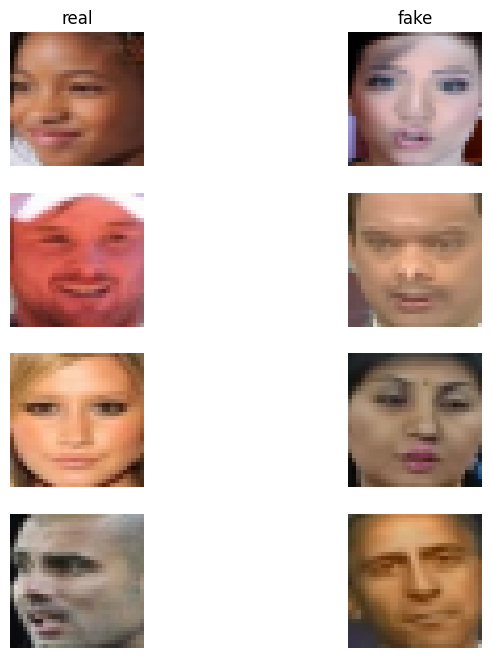

In [ ]:
from matplotlib import pyplot as plt
classes = ['real', 'fake']
num_classes = len(classes)
samples_per_class = 4
plt.figure(figsize=(8,8))
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(train_lbs == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(train_imgs[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()


### **3. Transform the dataset**
Our (train / val / test) input data have the shape of 4-D matrix `num_images x width x height x 3`, where 3 is the number of channels of each imag (Red, Green and Blue channel).
To fix into our SVM model, each of train / val / test dataset are transformed to a 2D matrix `num_images x F`, where `F = width x height x 3`.

In [ ]:
print('Training data shape: ', train_imgs.shape)
print('Validation labels shape: ' , val_imgs.shape)
print('Test data shape: ', test_imgs.shape)

Training data shape:  (14053, 32, 32, 3)
Validation labels shape:  (2003, 32, 32, 3)
Test data shape:  (4022, 32, 32, 3)


In [ ]:
import numpy as np

train_imgs_trans = train_imgs.reshape(train_imgs.shape[0], -1)
val_imgs_trans = val_imgs.reshape(val_imgs.shape[0], -1)
test_imgs_trans = test_imgs.reshape(test_imgs.shape[0], -1)

print('Transformed training data shape: ', train_imgs_trans.shape)
print('Transformed validation data shape: ', val_imgs_trans.shape)
print('Transformed test data shape: ', test_imgs_trans.shape)

Transformed training data shape:  (14053, 3072)
Transformed validation data shape:  (2003, 3072)
Transformed test data shape:  (4022, 3072)


In [ ]:
# Sanity check new shape of input data
print(train_imgs_trans.shape == (len(train_imgs), width*height*3))
print(val_imgs_trans.shape == (len(val_imgs), width*height*3))
print(test_imgs_trans.shape == (len(test_imgs), width*height*3))

True
True
True


Now, to normalize the data, mean of training data set is calculated. The mean vector will have the shape of `F`. And then subtract the mean from the training / val / test dataset.

In [ ]:
train_mean = np.mean(train_imgs_trans, axis=0)

# Sanity check shape of mean vector
print(train_mean.shape == (width*height*3,))

# Subtract mean from train / val / test
train_imgs_norm = train_imgs_trans - train_mean
val_imgs_norm = val_imgs_trans - train_mean
test_imgs_norm = test_imgs_trans - train_mean

True


### **4. Support Vector Machine**
In this section, we will build three different SVM models using different kernel, and report the acucracy on the validation data.

#### **4.1 Support vector machine with `linear` kernel**
Accuracy of *validation set* of SVM model with `linear` kernel, regularization parameter `C = 1.5`.
> **Result.** *0.8786819770344483*

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_linear = SVC(kernel='linear', C=1.5)
svm_linear.fit(train_imgs_norm, train_lbs)

SVC(C=1.5, kernel='linear')

In [ ]:
val_preds = svm_linear.predict(val_imgs_norm)
val_accuracy = accuracy_score(val_lbs, val_preds)
print('Accuracy of validation set of SVM model with linear kernel:', val_accuracy)

Accuracy of validation set of SVM model with linear kernel: 0.8786819770344483


#### **4.2 Support vector machine with `rbf` kernel**
Accuracy of *validation set* of SVM model with `rbf` kernel,  regularization parameter `C = 1.5`.
> **Result.** *0.9236145781328008*

In [ ]:
svm_rbf = SVC(kernel='rbf', C=1.5)
svm_rbf.fit(train_imgs_norm, train_lbs)

SVC(C=1.5)

In [ ]:
val_preds_rbf = svm_rbf.predict(val_imgs_norm)
val_accuracy_rbf = accuracy_score(val_lbs, val_preds_rbf)
print('Accuracy of validation set of SVM model with rbf kernel:', val_accuracy_rbf)

Accuracy of validation set of SVM model with rbf kernel: 0.9236145781328008


#### **4.3 Support vector machine with `poly` kernel**
Accuracy on the *validation set* of SVM model with `poly` kernel, regularization parameter `C = 1.5`.
> **Result.** *0.8941587618572142*

In [ ]:
svm_poly = SVC(kernel='poly', C=1.5)
svm_poly.fit(train_imgs_norm, train_lbs)

SVC(C=1.5, kernel='poly')

In [ ]:
val_preds_poly = svm_poly.predict(val_imgs_norm)
val_accuracy_poly = accuracy_score(val_lbs, val_preds_poly)
print('Accuracy of validation set of SVM model with poly kernel:', val_accuracy_poly)

Accuracy of validation set of SVM model with poly kernel: 0.8941587618572142


The RBF kernel SVM model demonstrated the best performance on the validation set among the three models (linear, RBF, and polynomial kernels). To determine the test set accuracy of this best-performing model, the RBF SVM was used to predict labels on the normalized test data (test_imgs_norm). The predicted labels (test_preds_rbf) were then compared to the actual test labels (test_lbs) using the accuracy_score function. This evaluation resulted in a test set accuracy of approximately 0.9324.

In [ ]:
test_preds_rbf = svm_rbf.predict(test_imgs_norm)

test_accuracy_rbf = accuracy_score(test_lbs, test_preds_rbf)
print('Accuracy of test set of SVM model with rbf kernel:', test_accuracy_rbf)

Accuracy of test set of SVM model with rbf kernel: 0.9323719542516161


In this project, we had gone through the use of training, validation and test set, and how to utilize them to develop a machine learning model. In fact, we can fine-tune the model more by changing its hyper-parameters.